# **S4E1: Bank Churn Binary Classification**

Table of Contents:
* [About the Project](#1)
* [About the Data](#2)
* [Set Up](#3)
* [EDA](#4)
* [Building the Model (XGB)](#5)
* [Submission](#6)
* [References](#7)

<a id="1"></a>
# **About the Project**

This project is part of Kaggle's [Playground Series](https://www.kaggle.com/competitions/playground-series-s4e1) (Season 4, Episode 1). The main goal of this project is to employ binary classification techniques to predict whether or not a customer continues with their bank account or closes it, i.e. churns. More specifically, I will be predicting the probability that a customer closes their account. 

In order to solve this binary classification problem, I will be using an XGBoost Classifier (XGB). Also known as Extreme Gradient Boosting, XGB is effectively a gradient-boosted decision tree which is often very effective in regression and classification tasks. In order to optimize the parameters of my XGB model, I will be using a code chunk used in my previous work: [Prediction of Cirrhosis Outcomes](https://www.kaggle.com/code/conradkleykamp/s3e26-prediction-of-cirrhosis-outcomes). This code chunk creates a study/trial using optuna and will help determine the best parameters for the model.  

I hope you enjoy this project! 

<a id="2"></a>
# **About the Data**

This dataset was provided by Kaggle and is available for use for the aforementioned Playground Series competition (Season 4, Episode 1). This dataset is synthetic data which was generated from an actual [Bank Customer Churn Prediction](https://www.kaggle.com/datasets/shubhammeshram579/bank-customer-churn-prediction) dataset. 

The target variable for this binary classfication task is 'Exited', i.e. whether the customer has churned (1 = yes, 0 = no). The following variables will be used as predictors:

- id
- CustomerID: a unique identifier for each customer
- Surname: the customer's last name
- CreditScore: a numerical value representing the customer's credit score
- Geography: the country where the customer resides (France, Spain, or Germany)
- Gender: the customer's gender (Male or Female)
- Age: the customer's age
- Tenure: the number of years the customer has had an acount with the bank
- Balance: the customer's account balance
- NumOfProducts: the number of bank products the customer has (e.g., savings account, credit card)
- HasCrCard: whether or not the customer has a credit card (1 = yes, 0 = no)
- IsActiveMember: whether or not the customer is an active member (1 = yes, 0 = no)
- EstimatedSalary: the customer's estimated salary

The dataset provided by Kaggle includes the following three .csv files:
- train
- test
- sample_submission

This dataset has a license that is subject to Kaggle's [Competition Rules](https://www.kaggle.com/competitions/playground-series-s4e1/rules#7-competition-data). 

<a id="3"></a>
# **Set Up**


In [1]:
# Loading necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('viridis')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
import optuna
import warnings
warnings.filterwarnings("ignore")
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.metrics import log_loss


In [2]:
# Loading in the data
train = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')
sample = pd.read_csv('/kaggle/input/playground-series-s4e1/sample_submission.csv')

<a id="4"></a>
# **EDA**


## **Viewing the 'train' Dataset**

In [3]:
# Viewing first 10 entries of the train dataset
train.head(10)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
5,5,15771669,Genovese,588,Germany,Male,36.0,4,131778.58,1,1.0,0.0,136024.31,1
6,6,15692819,Ch'ang,593,France,Female,30.0,8,144772.69,1,1.0,0.0,29792.11,0
7,7,15669611,Chukwuebuka,678,Spain,Male,37.0,1,138476.41,1,1.0,0.0,106851.60,0
8,8,15691707,Manna,676,France,Male,43.0,4,0.00,2,1.0,0.0,142917.13,0
9,9,15591721,Cattaneo,583,Germany,Male,40.0,4,81274.33,1,1.0,1.0,170843.07,0


In [4]:
# Viewing a summary description of the train dataset
sum_desc = pd.DataFrame(index = list(train))
sum_desc['Dtype'] = train.dtypes
sum_desc['Count'] = train.count()
sum_desc['#Unique'] = train.nunique()
sum_desc['%Unique'] = sum_desc['#Unique'] / len(train) * 100
sum_desc['#Null'] = train.isnull().sum()
sum_desc['%Null'] = sum_desc['#Null'] / len(train) * 100
sum_desc['Min'] = train.min()
sum_desc['Max'] = train.max()
sum_desc

,Dtype,Count,#Unique,%Unique,#Null,%Null,Min,Max
id,int64,165034,165034,100.000000,0,0.0,0,165033
CustomerId,int64,165034,23221,14.070434,0,0.0,15565701,15815690
Surname,object,165034,2797,1.694802,0,0.0,Abazu,Zuyeva
CreditScore,int64,165034,457,0.276913,0,0.0,350,850
Geography,object,165034,3,0.001818,0,0.0,France,Spain
Gender,object,165034,2,0.001212,0,0.0,Female,Male
Age,float64,165034,71,0.043021,0,0.0,18.0,92.0
Tenure,int64,165034,11,0.006665,0,0.0,0,10
Balance,float64,165034,30075,18.223518,0,0.0,0.0,250898.09
NumOfProducts,int64,165034,4,0.002424,0,0.0,1,4


Above, we can gain some brief insight into the structure of the train dataset. Notably, this dataset includes all 13 predictors and the single response variable 'Exited'. We can see that each of the 14 columns includes 165,034 rows or entries of data. This tells us that there are no missing values. Furthermore, we can see that each column is devoid of any null values. Lastly, we can see that several of the predictor variables are of object type (Surname, Geography, and Gender). For this classification task, I will be dropping unnecessary identifying predictors, such as id, CustomerId, and Surname, as these likely do not have an impact on the response variable. Furthermore, I will be converting any categorical variables (Geography and Gender) into numerical by using a label encoder, so that there are able to be used in our model. 

## **Viewing the 'test' Dataset**

In [5]:
# Viewing the first 10 entries of the test dataset
test.head(10)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00
5,165039,15672704,Pearson,593,France,Female,22.0,9,0.00,2,0.0,0.0,51907.72
6,165040,15647838,Onyemere,682,Spain,Male,45.0,4,0.00,2,1.0,1.0,157878.67
7,165041,15775307,Hargreaves,539,Spain,Female,47.0,8,0.00,2,1.0,1.0,126784.29
8,165042,15653937,Hsueh,845,France,Female,47.0,3,111096.91,1,1.0,0.0,94978.10
9,165043,15752344,Teng,645,Spain,Male,30.0,5,0.00,2,0.0,1.0,149195.44


In [6]:
# Viewing a summary description of the test dataset
sum_desc2 = pd.DataFrame(index = list(test))
sum_desc2['Dtype'] = test.dtypes
sum_desc2['Count'] = test.count()
sum_desc2['#Unique'] = test.nunique()
sum_desc2['%Unique'] = sum_desc['#Unique'] / len(test) * 100
sum_desc2['#Null'] = test.isnull().sum()
sum_desc2['%Null'] = sum_desc['#Null'] / len(test) * 100
sum_desc2['Min'] = test.min()
sum_desc2['Max'] = test.max()
sum_desc2

,Dtype,Count,#Unique,%Unique,#Null,%Null,Min,Max
id,int64,110023,110023,149.999546,0,0.0,165034,275056
CustomerId,int64,110023,19698,21.105587,0,0.0,15565701,15815690
Surname,object,110023,2708,2.542196,0,0.0,Abazu,Zuyeva
CreditScore,int64,110023,454,0.415368,0,0.0,350,850
Geography,object,110023,3,0.002727,0,0.0,France,Spain
Gender,object,110023,2,0.001818,0,0.0,Female,Male
Age,float64,110023,74,0.064532,0,0.0,18.0,92.0
Tenure,int64,110023,11,0.009998,0,0.0,0,10
Balance,float64,110023,22513,27.335194,0,0.0,0.0,250898.09
NumOfProducts,int64,110023,4,0.003636,0,0.0,1,4


Above, we can see the summary statistics of the test dataset. This dataset is similar to the train dataset but lacks the response variable 'Exited' and includes fewer entries of data, i.e., 110,023. Again, we can see that each column includes the same number of entries and no null values are present. As with the train dataset, I will also be modifying the test dataset. The predictors id, CustomerId, and Surname will be removed. And Geography and Gender will be converted to numerical. 

## **Converting Object-Type Predictors to Numerical**

In [7]:
# Converting Object-Type Columns to Numerical (train)
objects = train.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()
for col in objects:
    train[col] = label_encoder.fit_transform(train[col])

In [8]:
# Verifying train column types
train.dtypes

id                   int64
CustomerId           int64
Surname              int64
CreditScore          int64
Geography            int64
Gender               int64
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited               int64
dtype: object

Above, we can see that the label encoder has successfully changed the data types of Geography and Gender to int64. 

In [9]:
# Converting Object-Type Columns to Numerical (test)
objects2 = test.select_dtypes(include=['object']).columns
for col in objects2:
    test[col] = label_encoder.fit_transform(test[col])

In [10]:
# Verifying test column types
test.dtypes

id                   int64
CustomerId           int64
Surname              int64
CreditScore          int64
Geography            int64
Gender               int64
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
dtype: object

Again, this process has been repeated for the test dataset. All predictors are now in numerical format!

## **Removing Unnecessary Predictors**

As mentioned before, I will be removing the predictors id, CustomerId, and Surname from both train and test datasets. All of these predictors are essentially identifiers and thus will likely not impact the probability of bank churn. In other words, it is not likely that a bank customer's customer id or last name has a significant impact on whether or not they will keep or close their bank account. 

In [11]:
# Removing unnecessary predictors from train
train2 = train.drop(['id', 'CustomerId', 'Surname'], axis=1)

In [12]:
# Removing unnecessary predictors from test
test2 = test.drop(['id', 'CustomerId', 'Surname'], axis=1)

In [13]:
# Viewing reduced train dataset
train2.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,0,1,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,0,1,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,0,1,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,0,1,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,2,1,33.0,5,0.00,2,1.0,1.0,15068.83,0


Above, we can see the reduced train dataset (train2). This dataset now includes 10 predictors and the response variable 'Exited'. 

In [14]:
# Viewing reduced test dataset
test2.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,586,0,0,23.0,2,0.00,2,0.0,1.0,160976.75
1,683,0,0,46.0,2,0.00,1,1.0,0.0,72549.27
2,656,0,0,34.0,7,0.00,2,1.0,0.0,138882.09
3,681,0,1,36.0,8,0.00,1,1.0,0.0,113931.57
4,752,1,1,38.0,10,121263.62,1,1.0,0.0,139431.00


Again, we can see the reduced test dataset (test2). This dataset solely includes the 10 predictors. 

## **Distribution of Target Variable**

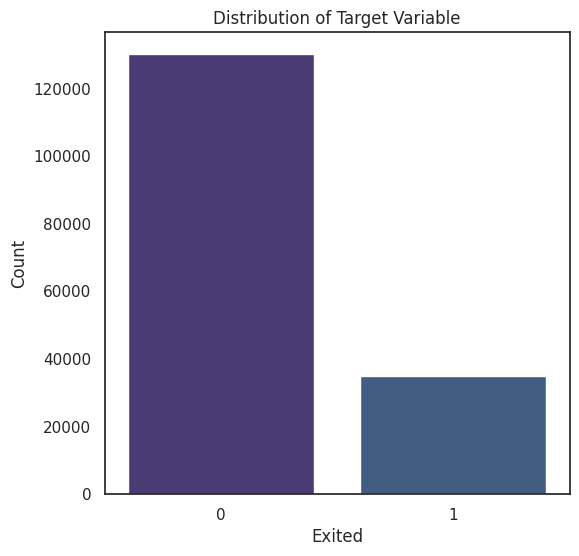

In [15]:
# Plotting distribution of target variable
plt.figure(figsize=(6, 6))
sns.countplot(x='Exited', data=train)
plt.title('Distribution of Target Variable')
plt.xlabel('Exited')
plt.ylabel('Count')
plt.show()

Here, we can see the distribution of the two classes of our response variable 'Exited'. As a reminder, the class 0 signifies that the customer did NOT exit their account, and the class 1 signifies that the customer DID exit their account. At a glance, it is clear that the vast majority of customers did NOT close their accounts. From this, we can argue that the classes are unbalanced. However, in real life, it is probability realistic that the majority of customers would keep their bank account. 

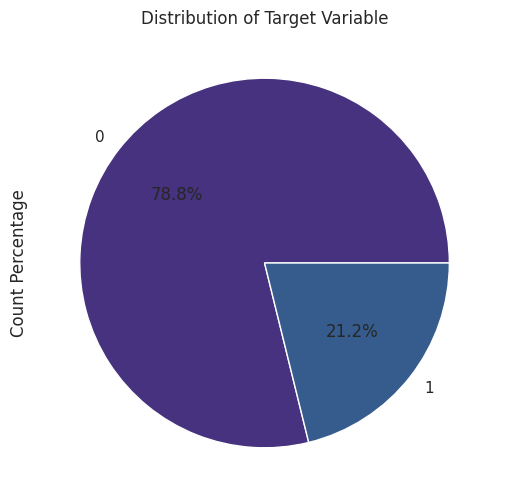

In [16]:
# Plotting distribution of target variable as pie plot
plt.figure(figsize=(6, 6))
train['Exited'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Distribution of Target Variable')
plt.ylabel('Count Percentage')
plt.show()

To further confirm this imbalance, we can plot the two classes in a pie plot. Here, we can see that ~78.8% of customers did NOT close their account, while only ~21.2% DID close their account. 

## **Distribution of Predictors**

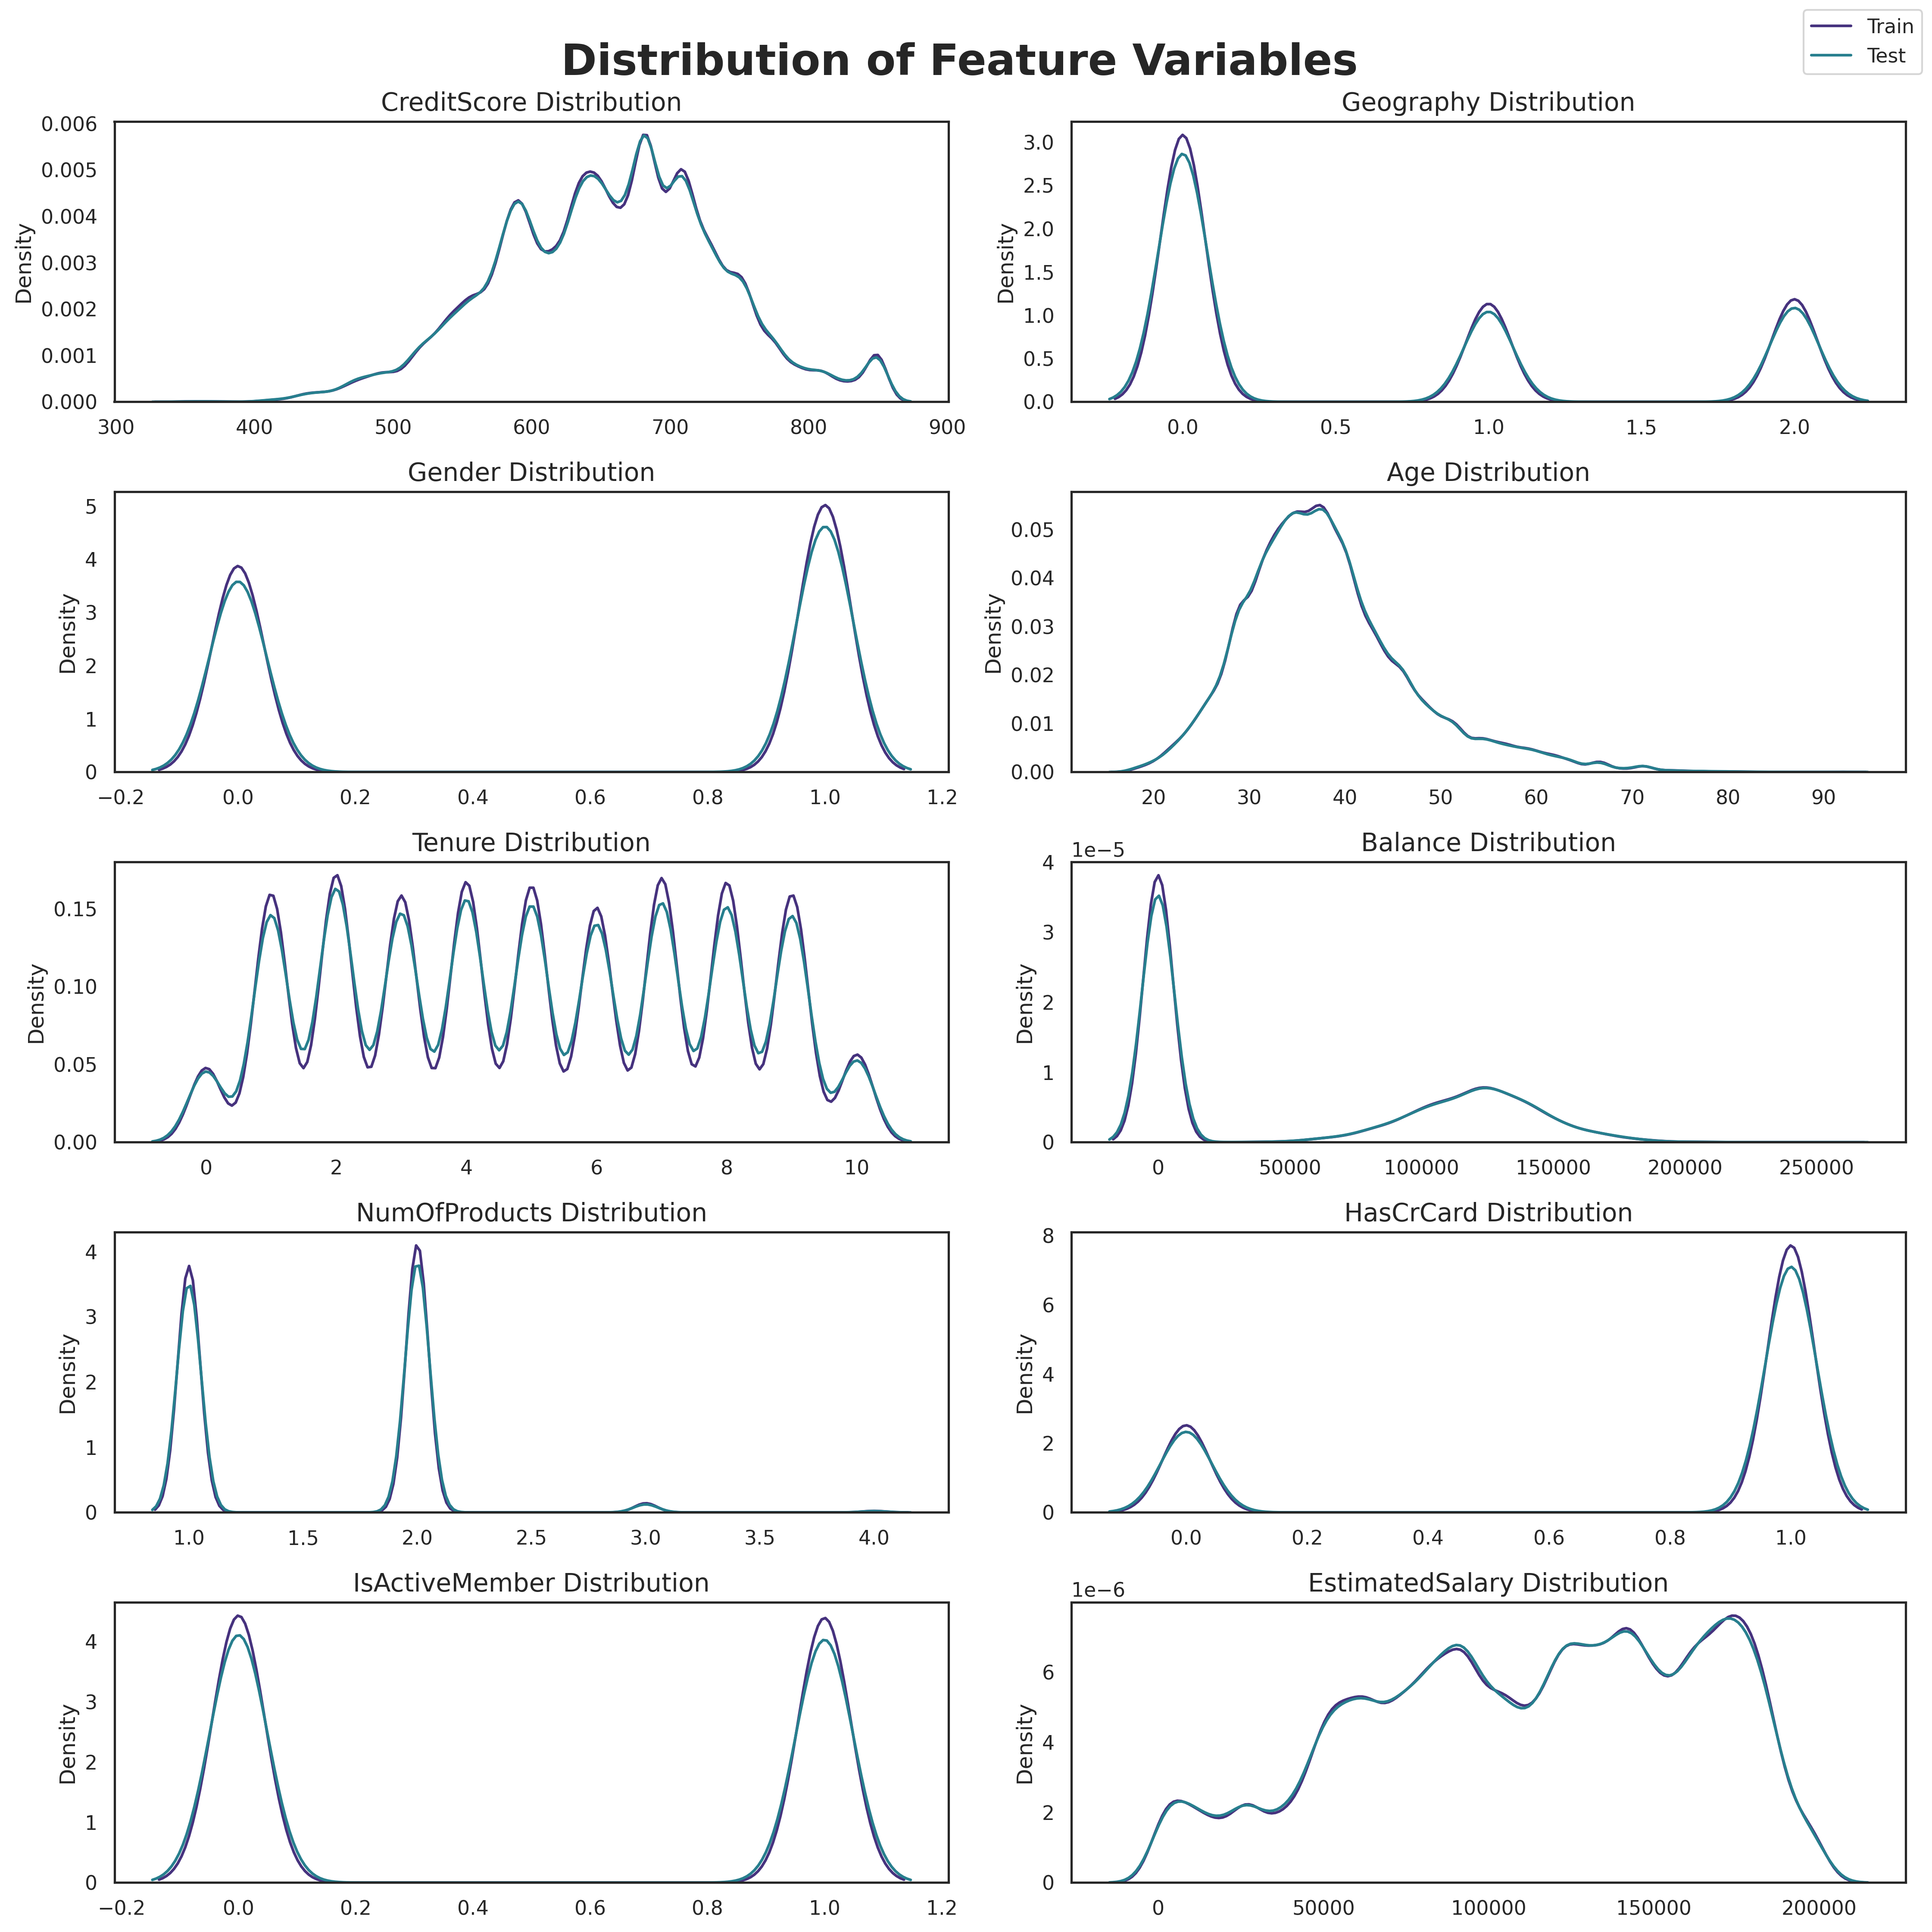

In [17]:
# Plotting distributions of feature variables
fig, ax = plt.subplots(5, 2, figsize = (15, 15), dpi = 300)
ax = ax.flatten()
train_features = train.drop(['id', 'CustomerId', 'Surname', 'Exited'], axis=1)
features = train_features.columns

for i, column in enumerate(features):
        
    sns.kdeplot(train[column], ax=ax[i], color=pal[0])
    sns.kdeplot(test[column], ax=ax[i], color=pal[2], warn_singular = False)
    
    ax[i].set_title(f'{column} Distribution', size = 14)
    ax[i].set_xlabel(None)
    
fig.suptitle('Distribution of Feature Variables', fontsize = 24, fontweight = 'bold')
fig.legend(['Train', 'Test'])
plt.tight_layout()

Above, we can see the distribution of the predictor variables. At glance, we can see that some variables have somewhat of an equal distribution, such as 'Gender', 'Tenure', and 'IsActiveMember'. Conversely, many other variables do not have an equal distribution. These include 'Geography' (the majority of customers are from France), 'NumOfProducts' (very few customers have >2 products), and 'HasCrCard' (the majority of customers have a credit card).  

## **Correlation of Features**

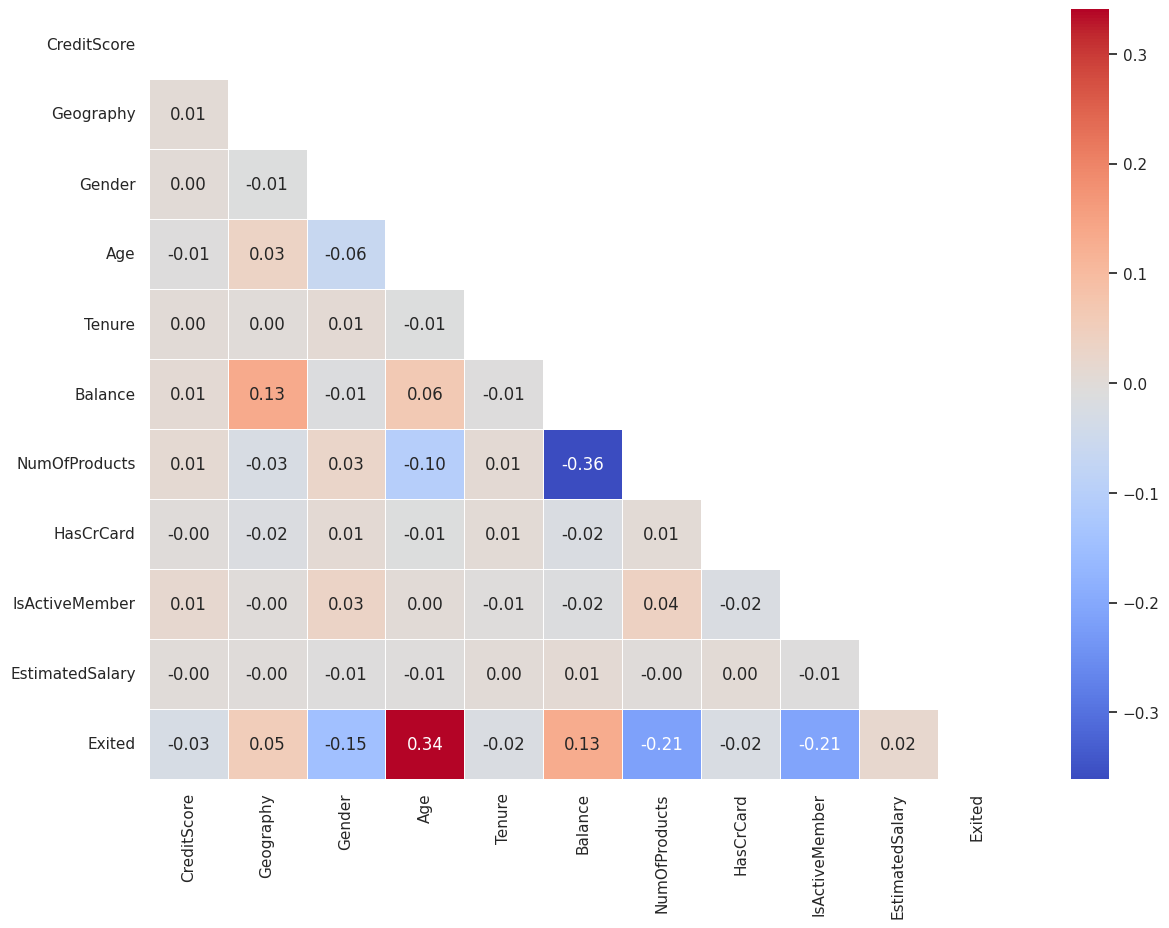

In [18]:
# Plotting heatmap
plt.figure(figsize=(14,10))
corr=train2.corr()
sns.heatmap(corr,annot=True,cmap='coolwarm',mask=np.triu(corr), linewidths=0.5, fmt=',.2f')
plt.show()

Here, we can see a heatmap showing the correlations amongst features and the target variable. At a glance, there appear to be no strong correlations between 'Exited' and any single predictor. In fact, the strongest correlation with 'Exited' is 'Age' at only 0.34. This does not seem too surprising, as one could postulate that as age increases to a certain point, the customer may either pass away or may no longer require the services of the bank. The only other interesting correlation here is between 'NumOfProducts' and 'Balance' at -0.36. While this correlation is not very strong, it may suggest that a higher balance may correlate with having fewer bank products. 

<a id="5"></a>
# **Building the Model (XGB Classifier)**

In [19]:
# Splitting train dataset, removing target variable
X = train2.drop(['Exited'], axis=1)
y = train2['Exited']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Setting up XGB
x = xgb.XGBClassifier(objective='multi:softmax', num_leaves=10)

In [21]:
# Running trial to determine best parameters, Kudos to Kala Nandini for this chunk!
def objective(trial):
    params = {
        'objective': 'multi:softprob',
        'num_class': len(set(y_train)),
        'eval_metric': 'mlogloss',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'eta': trial.suggest_loguniform('eta', 1e-8, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.0, 1.0),
        'min_child_weight': trial.suggest_uniform('min_child_weight', 0, 10),
        'subsample': trial.suggest_uniform('subsample', 0.0, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
    }
    
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_valid)
    loss = log_loss(y_valid, y_pred_proba)
    print('Loss:', loss)
    return loss

run=0

if run==1:

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)
    print('Best trial:')
    trial = study.best_trial

    print('Value: {}'.format(trial.value))
    print('Params: ')
    for key, value in trial.params.items():
        print(' {}: {}'.format(key, value))

In [22]:
# Recording best parameters from trial above
best_params = {'booster': 'dart',
              'lambda' : 2.5937106182057313e-07,
              'alpha' : 7.560396314093543e-05,
              'max_depth' : 4,
              'eta' : 0.21892553868920775,
              'gamma' : 0.10267441954552296,
              'colsample_bytree' : 0.657132660298427,
              'min_child_weight' : 6.385482708294288,
              'subsample' : 0.5611458391673437,
              'n_estimators' : 166}

In [23]:
# Creating/fitting model with best parameters
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train, y_train)
print('Training Error:', log_loss(y_valid, final_model.predict_proba(X_valid)))

Training Error: 0.3176242040330963


## **Conclusion**

The trial above was used to determine the best parameters for the XGB Classifier. As you can see here, the final model yielded a training error of 0.3176242040330963. Furthermore this model yielded a competition score of 0.88537! 

I hope you enjoyed this brief project. 

<a id="6"></a>
# **Submission**

In [24]:
sample = sample.drop(['Exited'], axis=1)
sample.head()

,id
0,165034
1,165035
2,165036
3,165037
4,165038


In [25]:
submission = final_model.predict_proba(test2)[:,1]
submission

array([0.03924418, 0.8139475 , 0.03268741, ..., 0.01814394, 0.12201244,
       0.14589426], dtype=float32)

In [26]:
sample['Exited'] = submission
sample.head()

,id,Exited
0,165034,0.039244
1,165035,0.813947
2,165036,0.032687
3,165037,0.224493
4,165038,0.355159


In [27]:
sample.to_csv('submission.csv', index=False)

<a id="7"></a>
# **References**

- https://www.kaggle.com/competitions/playground-series-s4e1
- https://www.kaggle.com/datasets/shubhammeshram579/bank-customer-churn-prediction
- https://www.kaggle.com/code/imnandini/multi-class-prediction-of-cirrhosis-beginner-level/notebook
- https://www.kaggle.com/code/conradkleykamp/s3e26-prediction-of-cirrhosis-outcomes